In [1]:
import sys
sys.path.append('../..')

import numpy as np
from qiskit import QuantumCircuit
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import HGate, TGate, ZGate, SGate, SdgGate, TdgGate
from utils.quantum_circuit import prepare_state, get_state_vector, calculate_fidelity, simulate, draw_state

In [2]:
n = 4
alice_bits = ''.join(f"{n}" for n in np.random.randint(2, size=n))
alice_bases_set = [[HGate], [HGate, SGate], [HGate, TGate], [HGate, ZGate]]
bob_bases_set = [[HGate], [SdgGate, HGate], [TdgGate, HGate], [ZGate, HGate]]
eve_bases_set = [[HGate], [HGate, SGate], [HGate, TGate], [HGate, ZGate]]
eve_decode_bases_set = [[HGate], [SdgGate, HGate], [TdgGate, HGate], [ZGate, HGate]]

print(f"Alice bits: {alice_bits}")

Alice bits: 1100


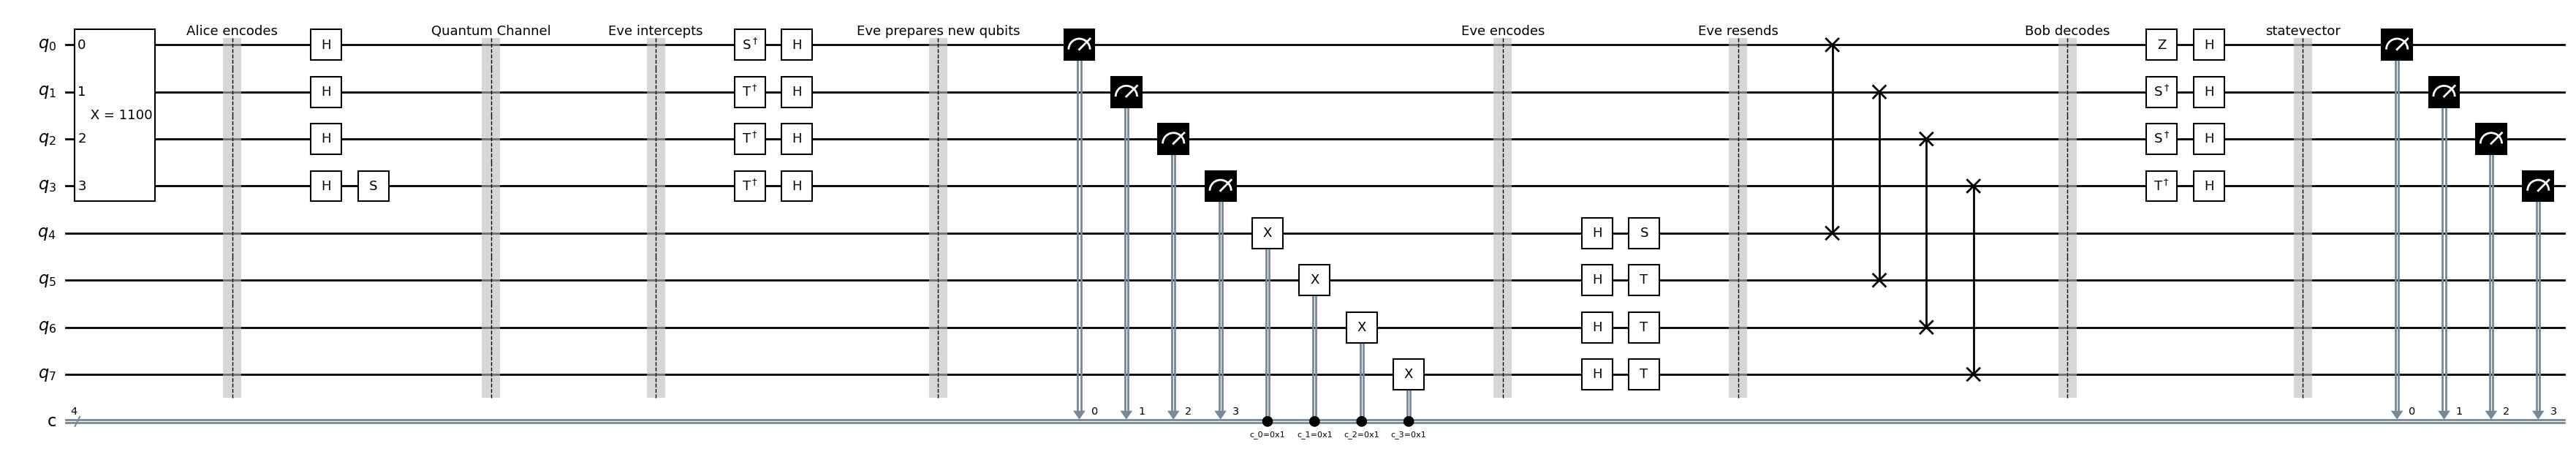

In [3]:
qc = QuantumCircuit(2*n, n)

# Alice prepares information state
qc.append(prepare_state(alice_bits, f" X = {alice_bits}"), [i for i in range(n)])

initial_state = get_state_vector(qc)

qc.barrier(label="Alice encodes")

# Alice encodes each qubit
for i in range(n):
    gates = alice_bases_set[np.random.choice(len(alice_bases_set))]
    for gate in gates:
        qc.append(gate(), [i])


qc.barrier(label="Quantum Channel")

qc.barrier(label="Eve intercepts")
eve_bases = []
for i in range(n):
    index = np.random.choice(len(eve_decode_bases_set))
    gates = eve_decode_bases_set[index]
    eve_bases.append(index)
    for gate in gates:
        qc.append(gate(), [i])

qc.barrier(label="Eve prepares new qubits")
for i in range(n):
    qc.measure(i, i)
    qc.x(i+n).c_if(qc.clbits[i], 1)

qc.barrier(label="Eve encodes")
for i in range(n):
    gates = eve_bases_set[eve_bases[i]]
    for gate in gates:
        qc.append(gate(), [i+n])

qc.barrier(label="Eve resends")
for i in range(n):
    qc.swap(i, i+n)

qc.barrier(label="Bob decodes")

# Bob prepare his bases to measure
for i in range(n):
    gates = bob_bases_set[np.random.choice(len(bob_bases_set))]
    for gate in gates:
        qc.append(gate(), [i])

qc.save_statevector()

qc.measure([i for i in range(n)], [i for i in range(n)])

qc.draw("mpl", style="bw", fold=-1)

In [4]:
result = simulate(qc, 8192)

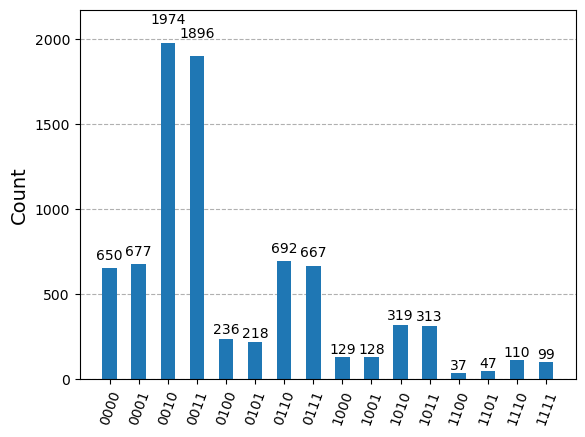

In [5]:
plot_histogram(result.get_counts())

In [6]:
draw_state(initial_state)

<IPython.core.display.Latex object>

In [7]:
last_state = result.get_statevector()
draw_state(last_state)

<IPython.core.display.Latex object>

In [8]:
calculate_fidelity(initial_state, last_state)

0.0